In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

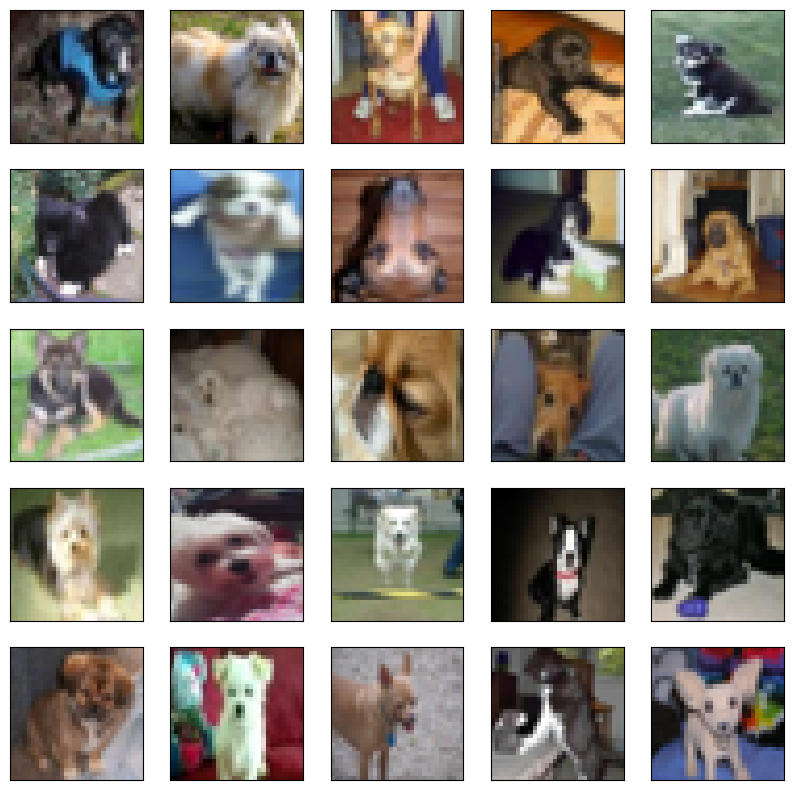

Nombre d'images: 5000


In [6]:
# Chargement du dataset CIFAR-10
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# filtre label 5 pour les chiens
dog_images = train_images[train_labels.flatten() == 5]

# Normalisation des images
dog_images = dog_images.reshape(dog_images.shape[0], 32, 32, 3).astype('float32')
dog_images = (dog_images - 127.5) / 127.5  # Normaliser les images à [-1, 1]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dog_images[i] * 0.5 + 0.5) 
plt.show()

print("Nombre d'images :", dog_images.shape[0])

In [7]:
def build_generator(z_dim):
    model = tf.keras.Sequential([
        layers.Dense(256 * 4 * 4, input_dim=z_dim, activation="relu"),
        layers.Reshape((4, 4, 256)),  # Redimensionnement : transforme la sortie dense en un format compatible
        layers.BatchNormalization(),  # Normalisation par lots : stabilise l'apprentissage en normalisant les activations.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation="relu"),  # Augmente la dimension spatiale de l'image.
        layers.BatchNormalization(),  # Nouvelle normalisation par lots après la convolution.
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation="relu"),  # Pour augmenter encore la dimension spatiale.
        layers.BatchNormalization(),  # Normalisation par lots.
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')  # Produit l'image RGB finale avec activation tanh -> pixels entre -1 et 1.
    ])
    return model

def build_discriminator(image_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=image_shape),  # Réduit la dimension spatiale: capture les caractéristiques de l'image.
        layers.LeakyReLU(alpha=0.2),  # Activation linéaire pour les valeurs négatives, ce qui aide à maintenir le flux des gradients.
        layers.Dropout(0.3),  # Dropout pour réduire le risque de surapprentissage en ignorant aléatoirement des unités lors de l'apprentissage.
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),  # Seconde couche de convolution, augmente la profondeur tout en réduisant la dimension spatiale.
        layers.LeakyReLU(alpha=0.2),  # Activation LeakyReLU.
        layers.Dropout(0.3), # Dropout.
        layers.Flatten(),  # Aplatit les activations en un vecteur pour l'entrée dans une couche dense.
        layers.Dense(1, activation='sigmoid')  # Couche dense finale avec activation sigmoïde pour la classification binaire.
    ])
    return model

In [8]:
@tf.function
def train_step(generator, discriminator, real_imgs, z_dim, batch_size):
    noise = tf.random.normal([batch_size, z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_imgs = generator(noise, training=True)
        real_output = discriminator(real_imgs, training=True)
        fake_output = discriminator(fake_imgs, training=True)

        d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
        d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
        d_loss = (d_loss_real + d_loss_fake) / 2
        g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_loss

def train_gan(generator, discriminator, images, z_dim, epochs=1000, batch_size=64):
    for epoch in range(epochs):
        for i in range(0, images.shape[0], batch_size):
            img_batch = images[i:i+batch_size]
            g_loss, d_loss = train_step(generator, discriminator, img_batch, z_dim, batch_size)

            if i % 10 == 0:
                print(f"Epoch: {epoch}, Batch: {i}, D Loss: {d_loss}, G Loss: {g_loss}")

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

z_dim = 100
generator = build_generator(z_dim)
discriminator = build_discriminator((32, 32, 3))

train_gan(generator, discriminator, dog_images, z_dim)

/home/mory/ia29/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mory/ia29/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mory/ia29/venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch: 0, Batch: 0, D Loss: 0.7031373977661133, G Loss: 0.6827864050865173
Epoch: 0, Batch: 320, D Loss: 0.6806766986846924, G Loss: 0.6987144947052002
Epoch: 0, Batch: 640, D Loss: 0.6611817479133606, G Loss: 0.7174344062805176
Epoch: 0, Batch: 960, D Loss: 0.6488063931465149, G Loss: 0.7224710583686829
Epoch: 0, Batch: 1280, D Loss: 0.6064993143081665, G Loss: 0.7690820097923279
Epoch: 0, Batch: 1600, D Loss: 0.5799459218978882, G Loss: 0.7966803312301636
Epoch: 0, Batch: 1920, D Loss: 0.5565133094787598, G Loss: 0.8308694362640381
Epoch: 0, Batch: 2240, D Loss: 0.5007764101028442, G Loss: 0.8777985572814941
Epoch: 0, Batch: 2560, D Loss: 0.4546339511871338, G Loss: 0.9681941270828247
Epoch: 0, Batch: 2880, D Loss: 0.4095683693885803, G Loss: 1.0803343057632446
Epoch: 0, Batch: 3200, D Loss: 0.3475181758403778, G Loss: 1.2766437530517578
Epoch: 0, Batch: 3520, D Loss: 0.28325411677360535, G Loss: 1.4068968296051025
Epoch: 0, Batch: 3840, D Loss: 0.22829657793045044, G Loss: 1.6197863

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


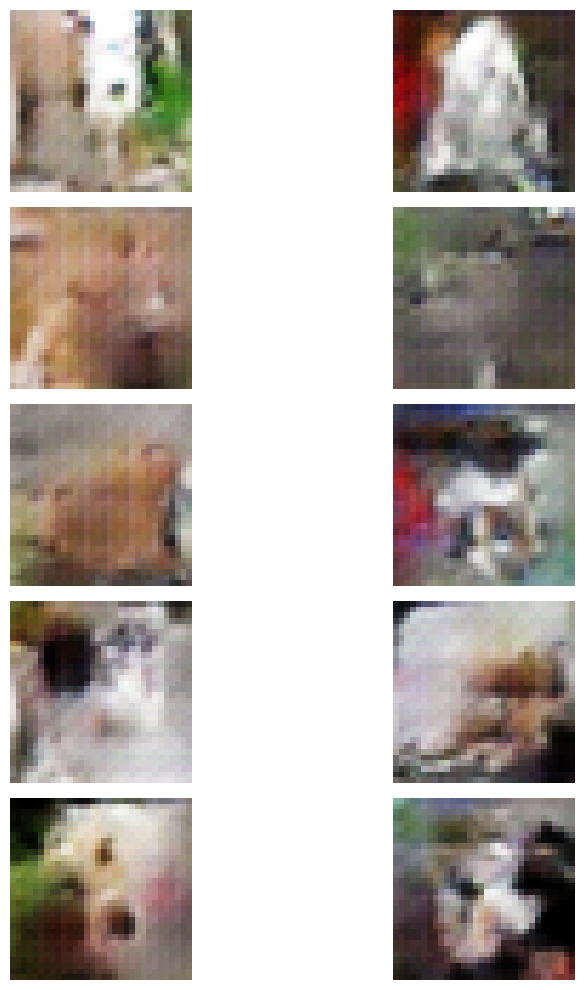

In [9]:
def generate_images(generator, z_dim, n_images=10):
    z = np.random.normal(0, 1, (n_images, z_dim))
    fake_images = generator.predict(z)
    fake_images = (fake_images + 1) / 2  # Normalisation pour affichage

    # Convertir les images pour sauvegarde : de [0, 1] à [0, 255]
    fake_images = (fake_images * 255).astype(np.uint8)

    if not os.path.exists('test'):
        os.makedirs('test')
    for i in range(n_images):
        cv2.imwrite('test/'+str(i)+'.jpg', cv2.cvtColor(fake_images[i], cv2.COLOR_RGB2BGR))

    return fake_images / 255.0

generated_images = generate_images(generator, z_dim, 10)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [25]:
generator.save('generator.keras')
